In [40]:
import sys
import os
import io
import boto3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score


In [41]:

load_dotenv('../.env')

def load_training_data():
    """Fetches all labeled parquet files from S3 and combines them."""
    bucket = os.getenv('S3_BUCKET_NAME')
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
        region_name='us-east-1'
    )
    
    print("Fetching labeled data from S3...")
    response = s3.list_objects_v2(Bucket=bucket, Prefix='training_data/')
    
    if 'Contents' not in response:
        print("No training data found.")
        return pd.DataFrame()
        
    dfs = []
    for obj in response['Contents']:
        if obj['Key'].endswith('.parquet'):
            data = s3.get_object(Bucket=bucket, Key=obj['Key'])['Body'].read()
            dfs.append(pd.read_parquet(io.BytesIO(data)))
            
    df = pd.concat(dfs, ignore_index=True)
    print(f"Successfully loaded {len(df)} labeled trades.")
    return df

In [42]:
def engineer_features(data):
    """Creates derived ratios and metrics for ML analysis."""
    d = data.copy()
    
    # 1. Distance to Strike (The Safety Cushion)
    # Positive means out-of-the-money (safer for covered calls)
    d['distance_to_strike_pct'] = (d['strike'] - d['stock_price']) / d['stock_price']
    
    # 2. Premium Yield (Reward)
    d['premium_yield'] = d['premium'] / d['stock_price']
    
    # 3. Liquidity Risk
    # High volume relative to open interest can signal a sudden breakout
    d['vol_oi_ratio'] = d['volume'] / (d['open_interest'] + 1)
    
    # 4. Days to Expiry (DTE)
    d['dte'] = (d['expiration_date'] - d['snapshot_date']).dt.days
    d['dte'] = d['dte'].replace(0, 1) # Prevent division by zero
    
    # 5. Annualized Yield
    d['annualized_yield'] = d['premium_yield'] * (365 / d['dte'])
    
    # 6. Risk-Adjusted Return
    # How much yield are we getting per unit of implied volatility?
    d['yield_to_iv_ratio'] = d['annualized_yield'] / (d['implied_volatility'] + 0.001)
    
    return d

In [43]:
df_raw = load_training_data()
df_ml_unclean = engineer_features(df_raw)

Fetching labeled data from S3...
Successfully loaded 16042 labeled trades.


In [44]:
def add_macro_features(df):
    print("Fetching macro data (VIX & SPY)...")
    
    start_date = df['snapshot_date'].min() - pd.Timedelta(days=14) 
    end_date = df['snapshot_date'].max() + pd.Timedelta(days=2)
    
    # Download data
    vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)
    spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)
    
    # Create DataFrame using the index from the downloaded data to avoid the ValueError
    macro_df = pd.DataFrame(index=spy_data.index)
    macro_df['vix'] = vix_data['Close']
    macro_df['spy_price'] = spy_data['Close']
    
    # Calculate trend
    macro_df['spy_5d_return'] = macro_df['spy_price'].pct_change(periods=5)
    
    # Rest of the merge logic...
    macro_df = macro_df.reset_index().rename(columns={'Date': 'snapshot_date'})
    macro_df['snapshot_date'] = pd.to_datetime(macro_df['snapshot_date']).dt.tz_localize(None)
    
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date']).dt.tz_localize(None)
    df_merged = pd.merge(df, macro_df[['snapshot_date', 'vix', 'spy_5d_return']], on='snapshot_date', how='left')
    
    return df_merged.ffill().dropna(subset=['vix', 'spy_5d_return'])

In [45]:
def clean_dataset(df):
    # Drop the single missing bid
    df_clean = df.dropna(subset=['bid']).copy()
    
    # Filter out absurd strikes (keep distance to strike <= 50%)
    df_clean = df_clean[df_clean['distance_to_strike_pct'] <= 0.50]
    
    return df_clean

In [46]:
df_ml_clean = clean_dataset(df_ml_unclean)
df_ml_macro = add_macro_features(df_ml_clean)
print(f"Training on clean dataset of {len(df_ml_macro)} rows.")

Fetching macro data (VIX & SPY)...
Training on clean dataset of 14796 rows.


In [53]:
features = [
    'delta', 'gamma', 'theta', 'vega', 'implied_volatility', 
    'distance_to_strike_pct', 'premium_yield', 'vol_oi_ratio', 
    'dte', 'yield_to_iv_ratio', 'vix', 'spy_5d_return'
]

X = df_ml_macro[features]
y = df_ml_macro['target_profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"Training on {len(X_train)} trades, Testing on {len(X_test)} trades.")

Training on 11836 trades, Testing on 2960 trades.


In [54]:
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
print("Model training complete!")

Model training complete!


--- Classification Report ---
              precision    recall  f1-score   support

       False       0.70      0.70      0.70      1334
        True       0.76      0.76      0.76      1626

    accuracy                           0.73      2960
   macro avg       0.73      0.73      0.73      2960
weighted avg       0.73      0.73      0.73      2960



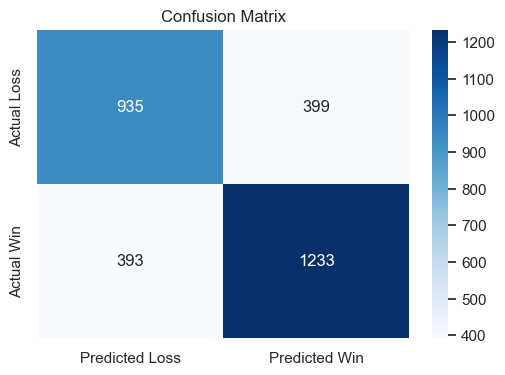

In [55]:
predictions = model.predict(X_test)

print("--- Classification Report ---")
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix')
plt.show()

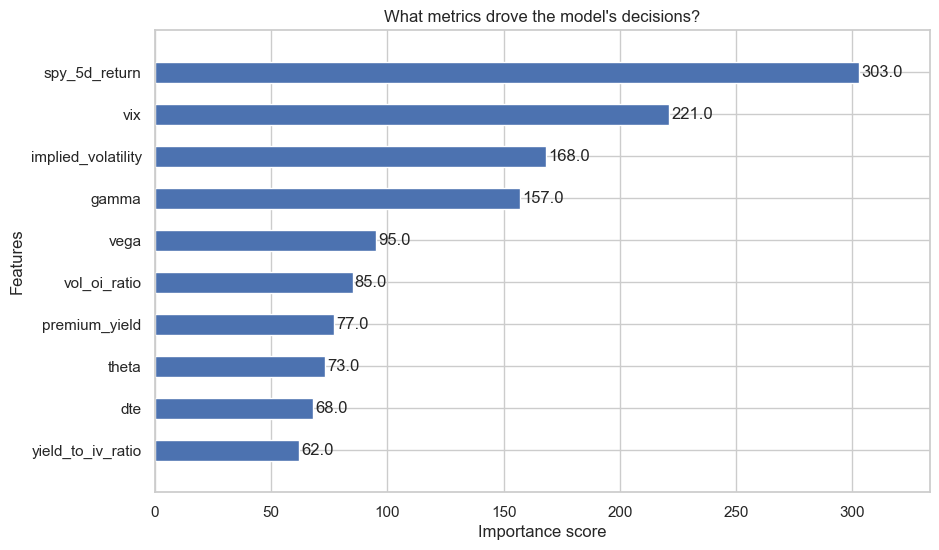

In [56]:
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.5)
plt.title("What metrics drove the model's decisions?")
plt.show()

In [57]:
# Get the model's raw probability score for a "Win" (Class 1)
probabilities = model.predict_proba(X_test)[:, 1]

# Test thresholds from 50% to 75% confidence
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

print("--- Threshold Optimization ---")
print(f"{'Confidence':<12} | {'Win Rate (Precision)':<22} | {'Trades Approved'}")
print("-" * 55)

for t in thresholds:
    # Approve trade only if probability is >= our threshold
    custom_preds = (probabilities >= t).astype(int)
    
    precision = precision_score(y_test, custom_preds, zero_division=0)
    trades_approved = sum(custom_preds)
    
    print(f"{t:>9.2f}    | {precision:>20.1%}   | {trades_approved:>15}")

--- Threshold Optimization ---
Confidence   | Win Rate (Precision)   | Trades Approved
-------------------------------------------------------
     0.50    |                75.6%   |            1632
     0.55    |                79.5%   |            1358
     0.60    |                83.4%   |            1107
     0.65    |                85.8%   |             845
     0.70    |                87.8%   |             625
     0.75    |                89.3%   |             477
